**Time-dependent synthetic control**

Find an adjacency matrix $A$ minimizing

$$
E(A) = \beta \left \| M - \hat{M} \right \|_F^2 + (1 - \beta) tr (\hat{M}^\top L \hat{M} )
$$

where
* *Global smoothness*: $tr (\hat{M}^\top L \hat{M} )$.
* *Local smoothness*: measured over the neighbourhood $\mathcal{N}(i)$ of node $i \in A$ as $\left \| m_i - \hat{m}_i \right \|_2^2$.
* The approximation to $m_i$ using only its neighbours is $$\hat{m}_i = \sum_{j \in \mathcal{N}(i)} S^{\tau^*_j}m_j \beta^*_j$$ using the shift operator $S$ with the optimal time shift $$\tau^*_j = \arg \max_t (m_i \star m_j)(t)$$
* Weights $\beta^*$ are given by OLS using the shifted neighbours.

**Optimization (simulated annealing)**

For each iteration:
1. Sample a new candidate $A_{n+1}$.
2. Evaluate $E(A_{n+1})$ and accept $A_{n+1}$ with some probability.

**Problem**

* Searching for $A$ is NP-hard.
* Shifting is computationally demanding.

**Question** 

* Do we need to shift profiles to minimize $\left \| m_i - \hat{m}_i \right \|_2^2$?

**Conclusions**

* Dont need time shift if eg using all other available profiles to approximate a target profile.
* Limiting to subset of overlapping profiles reduces performance since fewer samples.
* Using SC we can cluster the coefficients using k-means.

In [1]:
import sys
sys.path.append("../src/")

from time import time 

from scipy import signal
from scipy.sparse import csgraph

from sklearn.metrics import jaccard_score
from sklearn.linear_model import Ridge
from sklearn.cluster import SpectralClustering

import numpy as np 
import matplotlib.pyplot as plt

from graph_learning import (
    annealing, aquisition, utils, profile_synthesis
)

%matplotlib inline

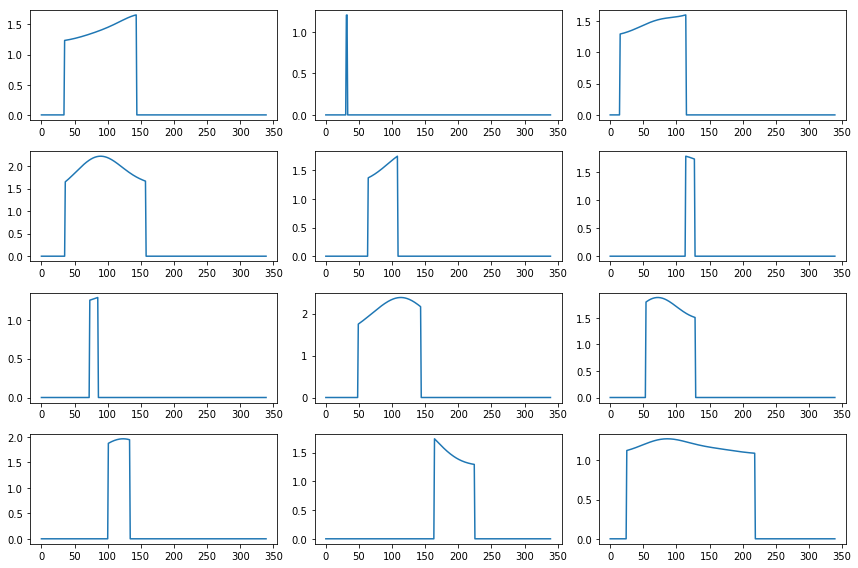

In [2]:
def interpolation_region_mask(Y):
    
    O = np.zeros_like(Y)
    for i, y in enumerate(Y):
        
        t_start = np.argmax(Y[i] != 0)
        t_end = np.argmax(np.cumsum(Y[i])) + 1
        
        O[i, t_start:t_end] = 1
        
    return O


def synthetic_data_gen():
    
    M = np.load("../data/M_train.npy")
    Y = np.load("../data/X_train.npy")
    #Z = np.load("../data/graph_learning/Z.npy")
    #A = np.load("../data/graph_learning/A.npy")
    
    O = interpolation_region_mask(Y)

    return M * O
    
    
def screening_data_gen():
    
    M = np.load("/Users/sela/Desktop/recsys_paper/results/screening/mf/train/train_Xrec.npy")
    Y = np.load("/Users/sela/Desktop/recsys_paper/data/screening/train/X_train.npy")
    O = interpolation_region_mask(Y)

    return M * O


# Choose between synthetic and screening data for demonstration run.
M = synthetic_data_gen()
#M = screening_data_gen()

# Examples of profiles.
_, axes = plt.subplots(ncols=3, nrows=4, figsize=(12, 8))
for i, axis in enumerate(axes.ravel()):
    axis.plot(M[i])
plt.tight_layout()

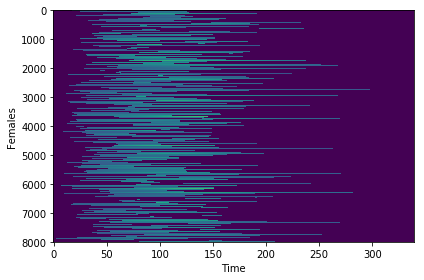

In [3]:
plt.figure()
plt.imshow(M, aspect="auto")
plt.xlabel("Time"); plt.ylabel("Females")
plt.tight_layout()

In [8]:
def loss(M, M_hat):
    
    return np.linalg.norm(np.array(M) - np.array(M_hat)) ** 2

# Profile synthesis with time shift

- **Sampling 10 neighbours to approximate each selected profile.**

Loss: 95.44119023850703


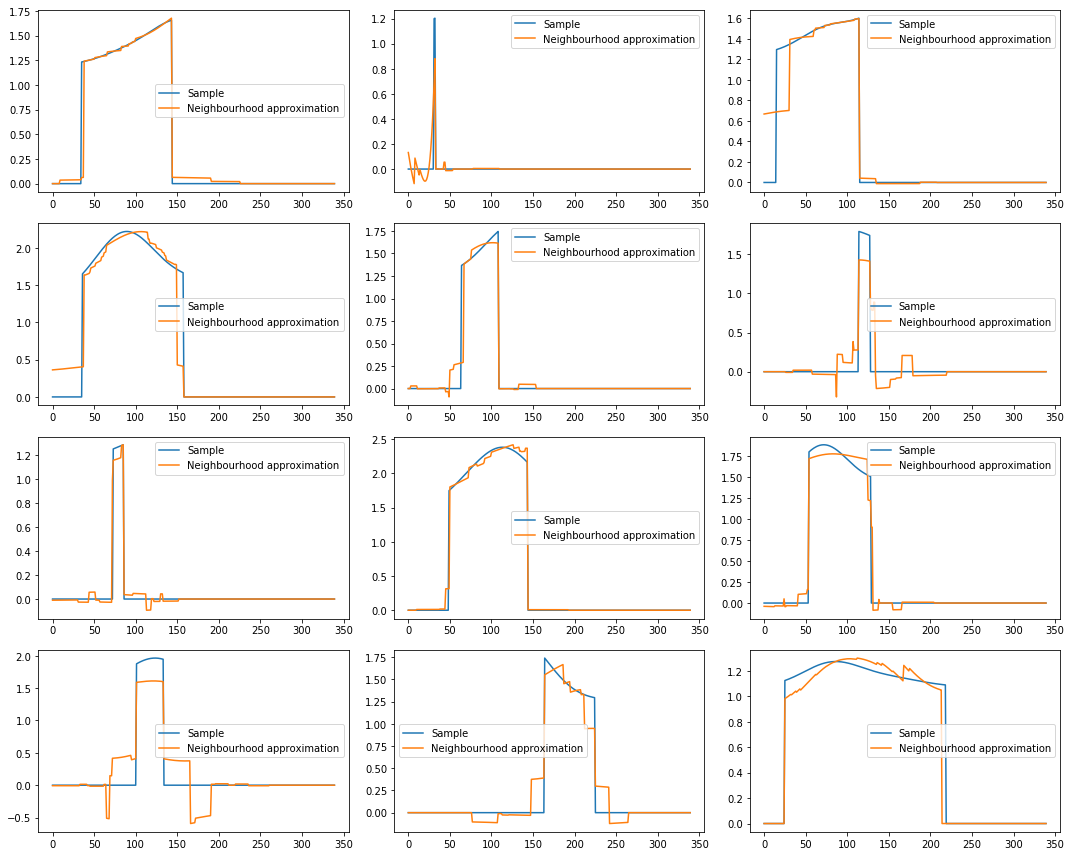

In [9]:
M_i, M_i_hat = [], []

np.random.seed(42)
_, axes = plt.subplots(ncols=3, nrows=4, figsize=(15, 12))
for i, axis in enumerate(axes.ravel()):
    
    M_i.append(M[i])
    
    # Select random neighbours for i.
    N_i = np.concatenate([np.arange(i), np.arange(i + 1, M.shape[0])])
    N_i = np.random.choice(N_i, size=10, replace=False)  
    
    # Find optimal alignment of elegible neighbours.
    tau_i_star, N_i_star, C_i_star = profile_synthesis.cross_correlation(i=i, N_i=N_i, M=M)
        
    aligned_neighbours = profile_synthesis.align(M[N_i_star], tau_i_star)
    m_i_hat = profile_synthesis.synthesize(i, M[i], aligned_neighbours)
    
    M_i_hat.append(m_i_hat)
    
    axis.plot(M[i], label="Sample")
    axis.plot(m_i_hat, label="Neighbourhood approximation")
    axis.legend()
    
plt.tight_layout()

print("Loss:", loss(M_i, M_i_hat))

# Profile synthesis without time shift

- **Sampling 10 neighbours to approximate each selected profile.**

Loss: 276.97000189048805


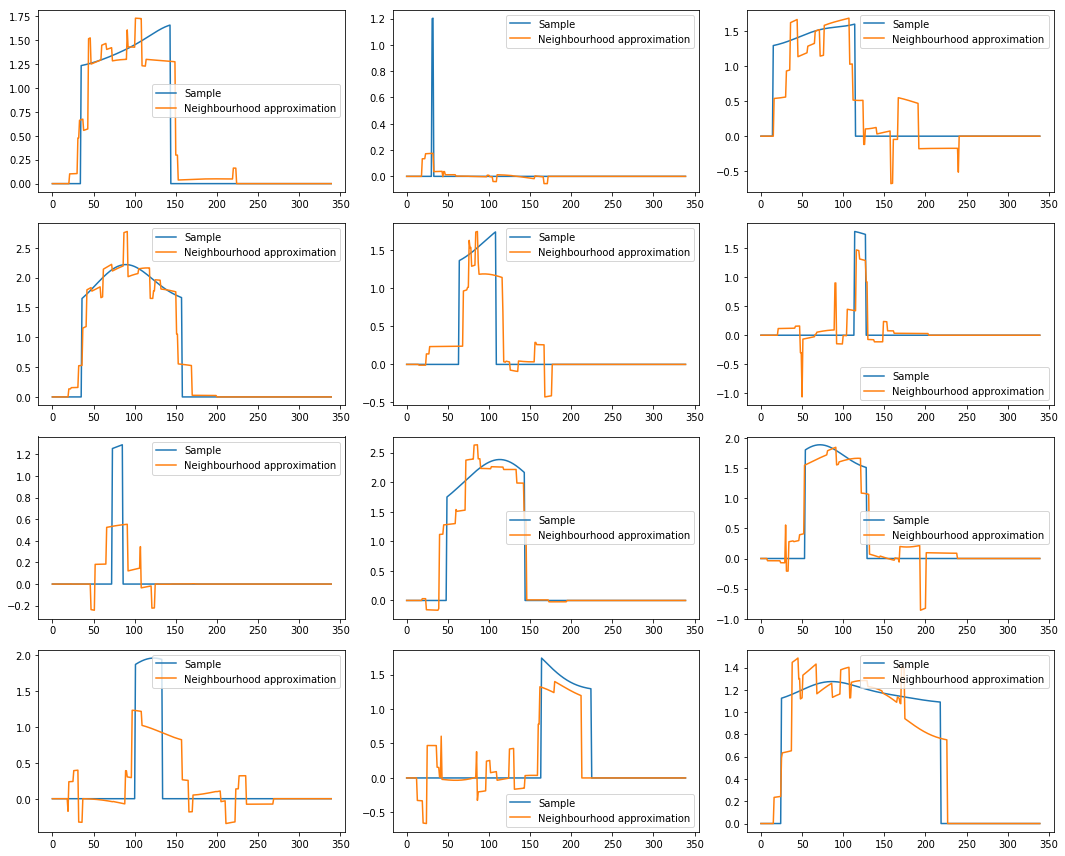

In [11]:
M_i, M_i_hat = [], []

np.random.seed(42)
_, axes = plt.subplots(ncols=3, nrows=4, figsize=(15, 12))
for i, axis in enumerate(axes.ravel()):
    
    M_i.append(M[i])
    
    # Select random neighbours for i.
    N_i = np.concatenate([np.arange(i), np.arange(i + 1, M.shape[0])])
    N_i = np.random.choice(N_i, size=10, replace=False)  
    
    m_i_hat = profile_synthesis.synthesize(i, M[i], M[N_i])
    
    M_i_hat.append(m_i_hat)
    
    axis.plot(M[i], label="Sample")
    axis.plot(m_i_hat, label="Neighbourhood approximation")
    axis.legend()
    
plt.tight_layout()

print("Loss:", loss(M_i, M_i_hat))

- **Using all available neighbours to approximate selected profiles.**

Loss: 1.80880795737448e-25


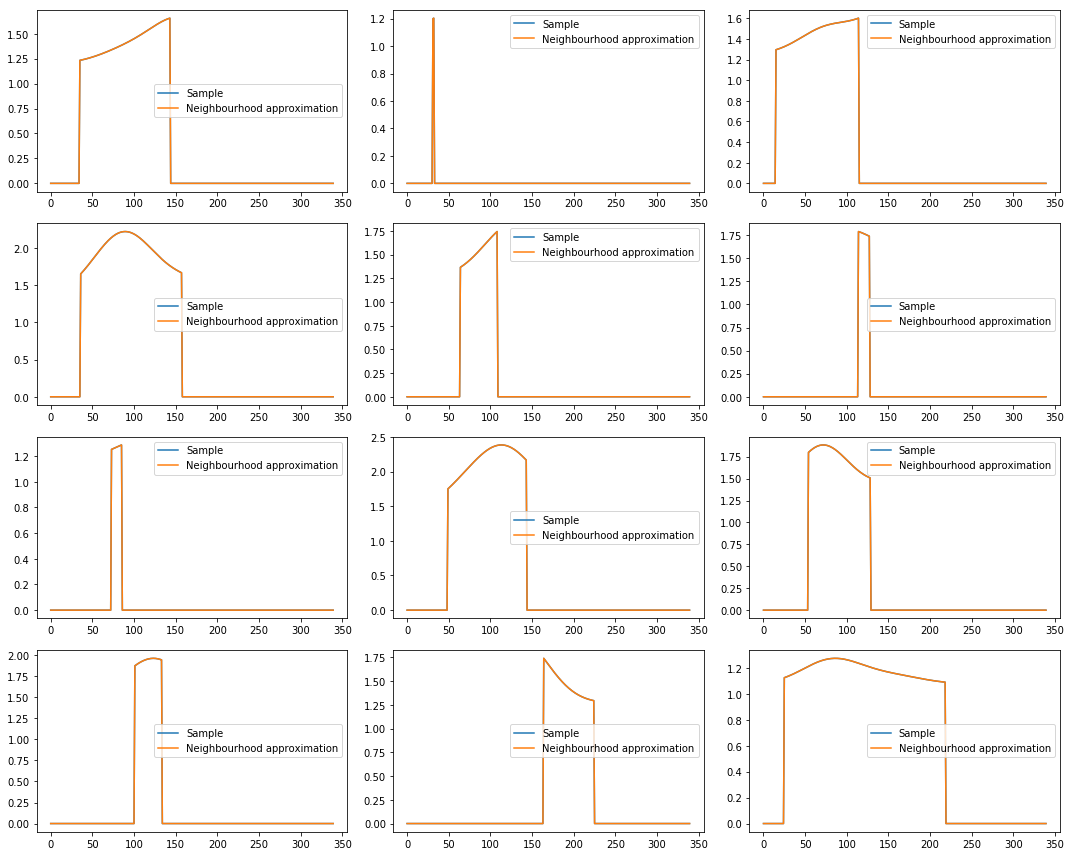

In [12]:
M_i, M_i_hat = [], []

np.random.seed(42)
_, axes = plt.subplots(ncols=3, nrows=4, figsize=(15, 12))
for i, axis in enumerate(axes.ravel()):
    
    M_i.append(M[i])
    
    N_i = np.concatenate([np.arange(i), np.arange(i + 1, M.shape[0])])
    
    m_i_hat = profile_synthesis.synthesize(i, M[i], M[N_i])
    
    M_i_hat.append(m_i_hat)
    
    axis.plot(M[i], label="Sample")
    axis.plot(m_i_hat, label="Neighbourhood approximation")
    axis.legend()
    
plt.tight_layout()

print("Loss:", loss(M_i, M_i_hat))

# Profiles overlapping with target profile to approximate

The donor profiles $m_j$ of some profile $m_i$ have to satisfy the following
* No donor profile can start later than $m_i$, i.e. $$\sup \tau^{(min)} < \tau^{(min)}_i, \quad \tau^{(min)}_k = \arg \max_t \mathbb{I} (m_{k, t} \neq 0)$$
* No donor profile can end earlier than $m_i$, i.e. $$\inf \tau^{(max)} > \tau^{(max)}_i, \quad \tau^{(max)}_k = \arg \max \sum_k m_k$$

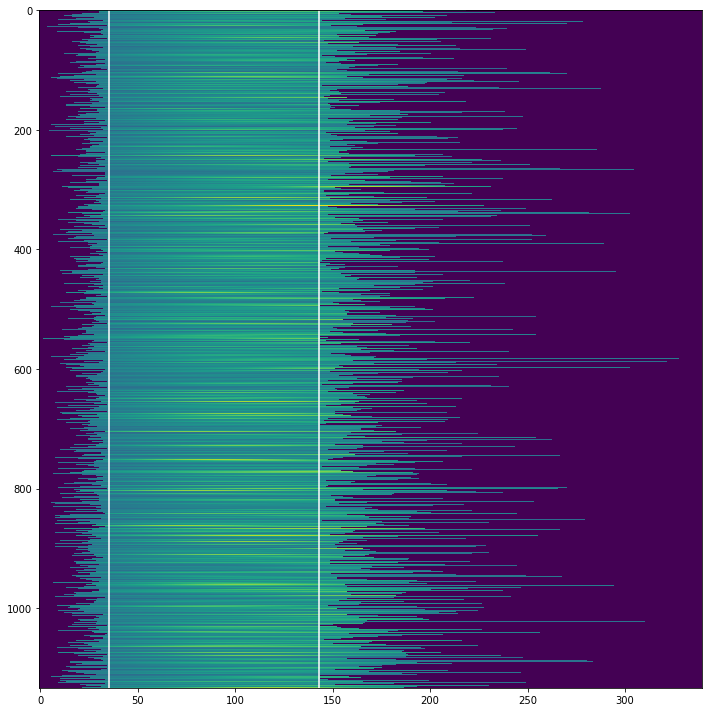

In [22]:
i = 0
t_start_i = np.argmax(M[i] != 0)
t_end_i = np.argmax(np.cumsum(M[i]))

M_j = profile_synthesis.overlaping_neighbours(M, i)

plt.figure(figsize=(10, 10))
plt.imshow(M_j, aspect="auto")
plt.axvline(x=t_start_i, c="w")
plt.axvline(x=t_end_i, c="w")
#plt.plot(m_i, c="r")
#plt.plot(M[i], c="r", linewidth=3)
plt.tight_layout()

# Profile synthesis without time shift using only overlapping profiles 

- **Sampling 10 neighbours to approximate each selected profile.**

247.9781854777495


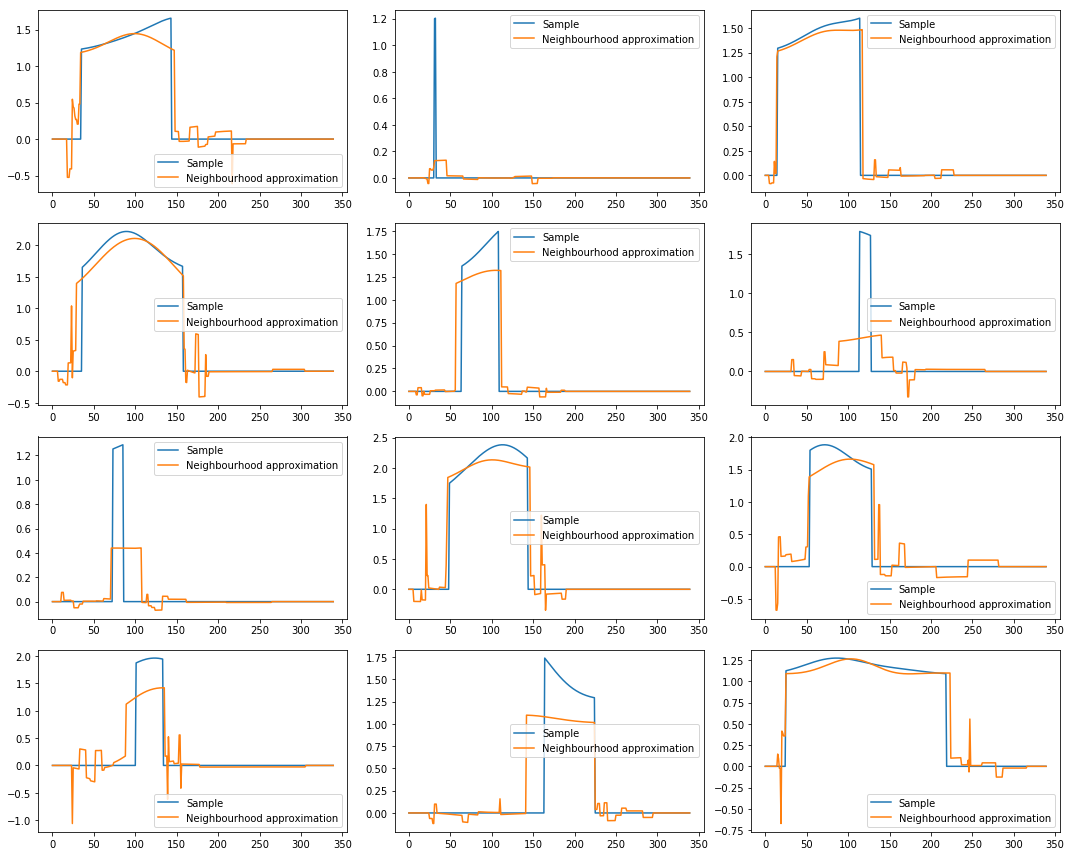

In [24]:
M_i, M_i_hat = [], []

np.random.seed(42)
_, axes = plt.subplots(ncols=3, nrows=4, figsize=(15, 12))
for i, axis in enumerate(axes.ravel()):
    
    M_i.append(M[i])
    
    # NOTE: Excludes profile i from donors.
    M_j = profile_synthesis.overlaping_neighbours(M, i)
    
    # Select random neighbours for i.
    N_i = np.random.choice(M_j.shape[0], size=10, replace=False)  
            
    m_i_hat = profile_synthesis.synthesize(i, M[i], M_j[N_i])
    
    M_i_hat.append(m_i_hat)
    
    axis.plot(M[i], label="Sample")
    axis.plot(m_i_hat, label="Neighbourhood approximation")
    axis.legend()
    
plt.tight_layout()

print(loss(M_i, M_i_hat))

- **Using all available neighbours to approximate selected profiles.**

1.7793539335995419


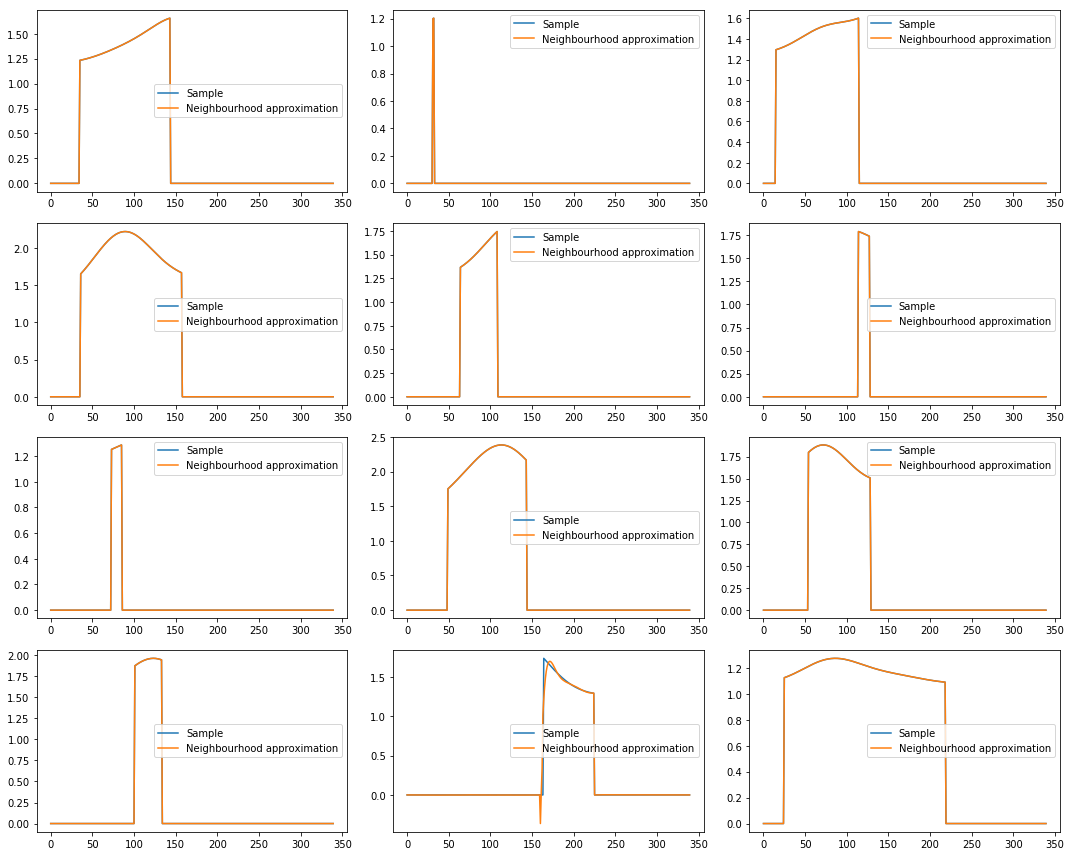

In [25]:
M_i, M_i_hat = [], []

np.random.seed(42)
_, axes = plt.subplots(ncols=3, nrows=4, figsize=(15, 12))
for i, axis in enumerate(axes.ravel()):
    
    M_i.append(M[i])
    
    # NOTE: Excludes profile i from donors.
    M_j = profile_synthesis.overlaping_neighbours(M, i)
    
    m_i_hat = profile_synthesis.synthesize(i, M[i], M_j)
    
    M_i_hat.append(m_i_hat)
    
    axis.plot(M[i], label="Sample")
    axis.plot(m_i_hat, label="Neighbourhood approximation")
    axis.legend()
    
plt.tight_layout()

print(loss(M_i, M_i_hat))